# Load raster data via WMS

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

import geoengine as ge

## Initialize Geo Engine

In [2]:
ge.initialize("http://localhost:3030/api")

In [3]:
session = ge.get_session()
session

Server:              http://localhost:3030/api
User Id:             f141c7b9-269c-45d8-9da5-c17f1c72d5e0
Session Id:          f9be0685-d662-486a-9626-e9b9c6c475b1
Session valid until: 2025-01-05T12:31:06.144Z

## Define workflow of Natural Earth 10m Ports

In [4]:
workflow = ge.register_workflow(
    {
        "type": "Vector",
        "operator": {"type": "OgrSource", "params": {"data": "ne_10m_ports", "attributeProjection": None}},
    }
)

workflow

2527ba30-375e-55d0-a54f-675ff6c21e71

## Define a query rectangle

In [5]:
time_start = datetime.strptime("2014-04-01T12:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z")
time_end = datetime.strptime("2014-06-01T12:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangle(
    ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
    ge.TimeInterval(time_start, time_end),
    ge.SpatialResolution(0.5, 0.5),
)

## Query dataset asynchronously

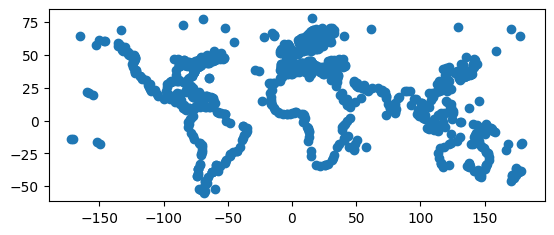

,natlscale,name,featurecla,scalerank,website,geometry,time_start,time_end
0,5.0,Sint Nicolaas,Port,8,www.rocargo.com/SanNicolas.html,MULTIPOINT (-69.92356 12.4375),NaT,NaT
1,5.0,Campana,Port,8,www.consejoportuario.com.ar,MULTIPOINT (-58.95141 -34.15333),NaT,NaT
2,5.0,Zarate,Port,8,www.consejoportuario.com.ar,MULTIPOINT (-59.00495 -34.09889),NaT,NaT
3,5.0,Puerto Belgrano/Bahia Blanca,Port,8,None,MULTIPOINT (-62.10088 -38.89444),NaT,NaT
4,5.0,Puerto Galvan/Bahia Blanca,Port,8,None,MULTIPOINT (-62.30053 -38.78306),NaT,NaT


In [6]:
async for data_frame in workflow.vector_stream(bbox):
    data_frame.plot()
    plt.show()
    display(data_frame.head())

## Query multiple batches of data

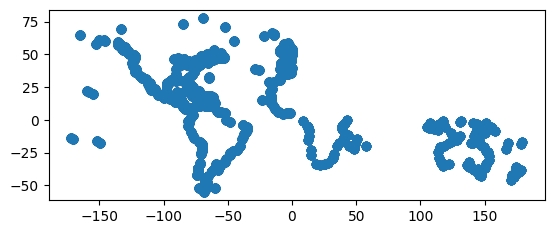

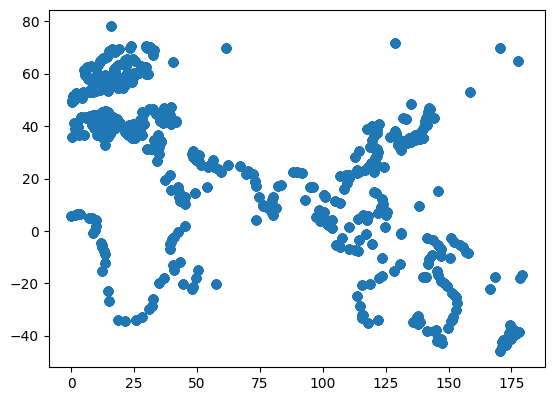

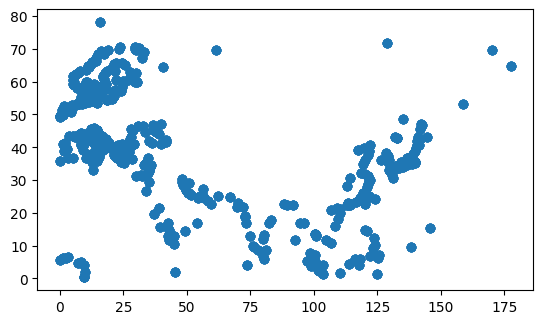

In [7]:
# we create a large data frame by repeating the data frame 160 times…
large_data_frame = pd.concat(
    [
        *[data_frame[["geometry", "scalerank", "natlscale"]].cx[-180:0, -90:0] for _ in range(40)],
        *[data_frame[["geometry", "scalerank", "natlscale"]].cx[-180:0, 0:90] for _ in range(40)],
        *[data_frame[["geometry", "scalerank", "natlscale"]].cx[0:180, -90:0] for _ in range(40)],
        *[data_frame[["geometry", "scalerank", "natlscale"]].cx[0:180, 0:90] for _ in range(40)],
    ],
    ignore_index=True,
)

# …then we upload it to the server…

new_id = ge.upload_dataframe(large_data_frame)

new_workflow = ge.register_workflow(
    {"type": "Vector", "operator": {"type": "OgrSource", "params": {"data": str(new_id), "attributeProjection": None}}}
)

# …and finally we can stream multiple batches from the server

async for chunk_data_frame in new_workflow.vector_stream(bbox):
    chunk_data_frame.plot()
    plt.show()

## Auto-merge into one geo data frame

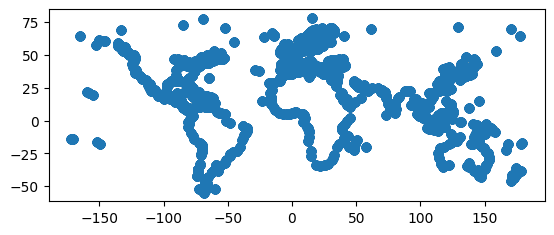

In [8]:
merged_data_frame = await new_workflow.vector_stream_into_geopandas(bbox)
merged_data_frame.plot()
plt.show()